In [124]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    if target_type in (np.int64, np.int32):
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)


In [125]:
import tensorflow as tf
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"housing.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('nox',1,inplace=True)
df.drop('zb',1,inplace=True)
df.drop('indus',1,inplace=True)
encode_numeric_zscore(df, 'crim')
#encode_numeric_zscore(df, 'zb')
#encode_numeric_zscore(df, 'indus')
#encode_numeric_zscore(df, 'nox')
encode_numeric_zscore(df, 'rm')
encode_numeric_zscore(df, 'age')
encode_numeric_zscore(df, 'dis')
encode_numeric_zscore(df, 'rad')
encode_numeric_zscore(df, 'tax')
encode_numeric_zscore(df, 'ptratio')
encode_numeric_zscore(df, 'b')
encode_numeric_zscore(df, 'lstat')
encode_numeric_zscore(df, 'medv')
encode_text_dummy(df, 'chas')

df
x,y = to_xy(df,['medv'])

model_dir = 'tmp/medva' 

opt= tf.train.AdagradOptimizer(learning_rate=0.1, initial_accumulator_value=0.1)
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = skflow.DNNRegressor(
    optimizer=opt,
    model_dir= model_dir,
    feature_columns=feature_columns,
    hidden_units=[100, 50, 25])

regressor.fit(x, y,steps=1000)

pred = list(regressor.predict(x, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

pred = list(regressor.predict(x, as_iterable=True))
predDF = pd.DataFrame(pred)
df2 = pd.concat([df,predDF,pd.DataFrame(y)],axis=1)

df2.columns = list(df.columns)+['pred','ideal']
df2



Final score (RMSE): 0.014460102654993534


,crim,rm,age,dis,rad,tax,ptratio,b,lstat,medv,chas-0,chas-1,pred,ideal
0,-0.419367,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499,0.159528,1,0,0.166084,0.159528
1,-0.416927,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953,-0.101424,1,0,-0.092114,-0.101424
2,-0.416929,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532,1.322937,1,0,1.331941,1.322937
3,-0.416338,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171,1.181589,1,0,1.182335,1.181589
4,-0.412074,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487,1.486032,1,0,1.491460,1.486032
5,-0.416631,0.206892,-0.350810,1.076671,-0.752178,-1.105022,0.112920,0.410165,-1.042291,0.670558,1,0,0.651690,0.670558
6,-0.409837,-0.388027,-0.070159,0.838414,-0.522484,-0.576948,-1.503749,0.426376,-0.031237,0.039925,1,0,0.026682,0.039925
7,-0.403297,-0.160307,0.977841,1.023625,-0.522484,-0.576948,-1.503749,0.440616,0.909800,0.496590,1,0,0.509440,0.496590
8,-0.395543,-0.930285,1.116390,1.086122,-0.522484,-0.576948,-1.503749,0.328123,2.419379,-0.655946,1,0,-0.648712,-0.655946
9,-0.400333,-0.399413,0.615481,1.328320,-0.522484,-0.576948,-1.503749,0.329000,0.622728,-0.394995,1,0,-0.383089,-0.394995


In [126]:
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"housing.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('nox',1,inplace=True)
df.drop('zb',1,inplace=True)
df.drop('indus',1,inplace=True)
encode_numeric_zscore(df, 'crim')
#encode_numeric_zscore(df, 'zb')
#encode_numeric_zscore(df, 'indus')
#encode_numeric_zscore(df, 'nox')
encode_numeric_zscore(df, 'rm')
encode_numeric_zscore(df, 'age')
encode_numeric_zscore(df, 'dis')
encode_numeric_zscore(df, 'rad')
encode_numeric_zscore(df, 'tax')
encode_numeric_zscore(df, 'ptratio')
encode_numeric_zscore(df, 'b')
encode_numeric_zscore(df, 'lstat')
encode_numeric_zscore(df, 'medv')
encode_text_dummy(df, 'chas')

df

x,y = to_xy(df,['medv'])

model_dir = 'tmp/meb' 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

opt= tf.train.AdagradOptimizer(learning_rate=0.1, initial_accumulator_value=0.1)
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = skflow.DNNRegressor(
    optimizer=opt,
    model_dir= model_dir,
    feature_columns=feature_columns,
    hidden_units=[100, 50, 25])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)



DNNRegressor(feature_columns=[_RealValuedColumn(column_name='', dimension=506, default_value=None, dtype=tf.float32, normalizer=None)], hidden_units=[100, 50, 25], optimizer=<tensorflow.python.training.adagrad.AdagradOptimizer object at 0x7f8d400d2358>, dropout=None)

In [127]:
tf.logging.set_verbosity(tf.logging.ERROR)

pred = list(regressor.predict(x_test, as_iterable=True))

score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.001414737431332469


In [128]:
tf.logging.set_verbosity(tf.logging.ERROR)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.037612996995449066


In [129]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"housing.csv")
filename_write = os.path.join(path,"housing-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])


df.drop('nox',1,inplace=True)
df.drop('zb',1,inplace=True)
df.drop('indus',1,inplace=True)
encode_numeric_zscore(df, 'crim')
#encode_numeric_zscore(df, 'zb')
#encode_numeric_zscore(df, 'indus')
#encode_numeric_zscore(df, 'nox')
encode_numeric_zscore(df, 'rm')
encode_numeric_zscore(df, 'age')
encode_numeric_zscore(df, 'dis')
encode_numeric_zscore(df, 'rad')
encode_numeric_zscore(df, 'tax')
encode_numeric_zscore(df, 'ptratio')
encode_numeric_zscore(df, 'b')
encode_numeric_zscore(df, 'lstat')
encode_numeric_zscore(df, 'medv')
encode_text_dummy(df, 'chas')


np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

x,y = to_xy(df,'medv')

kf = KFold(5)
    
all_y = []
all_pred = []
fold = 0
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model_dir = 'tmp/meKF' + str(fold)
    
    opt= tf.train.AdagradOptimizer(learning_rate=0.1, initial_accumulator_value=0.1)
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = skflow.DNNRegressor(
         optimizer=opt,
         model_dir= model_dir,
         feature_columns=feature_columns,
         hidden_units=[100, 50, 25])

    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    pred = list(regressor.predict(x_test, as_iterable=True))
    
    all_y.append(y_test)
    all_pred.append(pred)        

    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
score1 = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score1))
score = np.sqrt(metrics.mean_squared_error(all_pred,all_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

all_y = pd.DataFrame(all_y)
all_pred = pd.DataFrame(all_pred)
allDF = pd.concat( [df, all_y, all_pred],axis=1 )
allDF.to_csv(filename_write,index=False)

Fold #1
Fold score (RMSE): 0.40426287055015564
Fold #2
Fold score (RMSE): 0.3568691611289978
Fold #3
Fold score (RMSE): 0.4648118019104004
Fold #4
Fold score (RMSE): 0.379515677690506
Fold #5
Fold score (RMSE): 0.309773325920105
Final score (MSE): 0.09595952183008194
Final, out of sample score (RMSE): 0.3865138292312622


In [130]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"housing.csv")
filename_write = os.path.join(path,"housing-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])


df.drop('nox',1,inplace=True)
df.drop('zb',1,inplace=True)
df.drop('indus',1,inplace=True)
encode_numeric_zscore(df, 'crim')
#encode_numeric_zscore(df, 'zb')
#encode_numeric_zscore(df, 'indus')
#encode_numeric_zscore(df, 'nox')
encode_numeric_zscore(df, 'rm')
encode_numeric_zscore(df, 'age')
encode_numeric_zscore(df, 'dis')
encode_numeric_zscore(df, 'rad')
encode_numeric_zscore(df, 'tax')
encode_numeric_zscore(df, 'ptratio')
encode_numeric_zscore(df, 'b')
encode_numeric_zscore(df, 'lstat')
encode_numeric_zscore(df, 'medv')
encode_text_dummy(df, 'chas')


np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

x,y = to_xy(df,'medv')

x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 

kf = KFold(5)
    
all_y = []
all_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model_dir = 'tmp/meKFHS' + str(fold)
    
    opt= tf.train.AdagradOptimizer(learning_rate=0.1, initial_accumulator_value=0.1)
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
    regressor = skflow.DNNRegressor(
         optimizer=opt,
         model_dir= model_dir,
         feature_columns=feature_columns,
         hidden_units=[100, 50, 25])

    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        x_test,
        y_test,
        every_n_steps=50,
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=50)
    
    regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

    pred = list(regressor.predict(x_test, as_iterable=True))
    
    all_y.append(y_test)
    all_pred.append(pred)        
    score1 = metrics.mean_squared_error(pred,y_test)
    print("Fold score (MSE): {}".format(score1))
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))
   

all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
score = np.sqrt(metrics.mean_squared_error(all_pred,all_y))
print()
print("Cross-validated score (RMSE): {}".format(score))    
    
holdout_pred = list(regressor.predict(x_holdout, as_iterable=True))

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print("Holdout score (RMSE): {}".format(score)) 

Fold #1
Fold score (MSE): 0.11733327805995941
Fold score (RMSE): 0.3425394594669342
Fold #2
Fold score (MSE): 0.14659762382507324
Fold score (RMSE): 0.38288068771362305
Fold #3
Fold score (MSE): 0.19778668880462646
Fold score (RMSE): 0.4447321593761444
Fold #4
Fold score (MSE): 0.10027521848678589
Fold score (RMSE): 0.31666263937950134
Fold #5
Fold score (MSE): 0.16740913689136505
Fold score (RMSE): 0.4091566205024719

Cross-validated score (RMSE): 0.3819429278373718
Holdout score (RMSE): 0.41510075330734253


In [131]:
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

Score (MSE): 0.1741606593132019
Score (RMSE): 0.41732561588287354


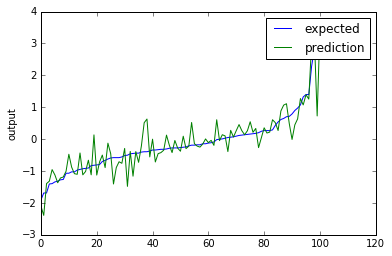

In [132]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"housing.csv")
filename_write = os.path.join(path,"housing-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])


df.drop('nox',1,inplace=True)
df.drop('zb',1,inplace=True)
df.drop('indus',1,inplace=True)
encode_numeric_zscore(df, 'crim')
#encode_numeric_zscore(df, 'zb')
#encode_numeric_zscore(df, 'indus')
#encode_numeric_zscore(df, 'nox')
encode_numeric_zscore(df, 'rm')
encode_numeric_zscore(df, 'age')
encode_numeric_zscore(df, 'dis')
encode_numeric_zscore(df, 'rad')
encode_numeric_zscore(df, 'tax')
encode_numeric_zscore(df, 'ptratio')
encode_numeric_zscore(df, 'b')
encode_numeric_zscore(df, 'lstat')
encode_numeric_zscore(df, 'medv')
encode_text_dummy(df, 'chas')


x,y = to_xy(df,'medv')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model_dir = 'tmp/mec' 

opt= tf.train.AdagradOptimizer(learning_rate=0.1, initial_accumulator_value=0.1)
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = skflow.DNNRegressor(
     optimizer=opt,
     model_dir= model_dir,
     feature_columns=feature_columns,
     hidden_units=[100, 50, 25])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=32,steps=10000)

pred = list(regressor.predict(x_test, as_iterable=True))
score1 = metrics.mean_squared_error(pred,y_test)
print("Score (MSE): {}".format(score1))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))


chart_regression(pred,y_test)